Epoch 1/10, Train Loss: 0.1345, Validation Accuracy: 0.9849
Epoch 2/10, Train Loss: 0.0435, Validation Accuracy: 0.9890
Epoch 3/10, Train Loss: 0.0287, Validation Accuracy: 0.9898
Epoch 4/10, Train Loss: 0.0213, Validation Accuracy: 0.9896
Epoch 5/10, Train Loss: 0.0180, Validation Accuracy: 0.9894
Epoch 6/10, Train Loss: 0.0145, Validation Accuracy: 0.9905
Epoch 7/10, Train Loss: 0.0119, Validation Accuracy: 0.9892
Epoch 8/10, Train Loss: 0.0108, Validation Accuracy: 0.9888
Epoch 9/10, Train Loss: 0.0086, Validation Accuracy: 0.9883
Epoch 10/10, Train Loss: 0.0091, Validation Accuracy: 0.9906


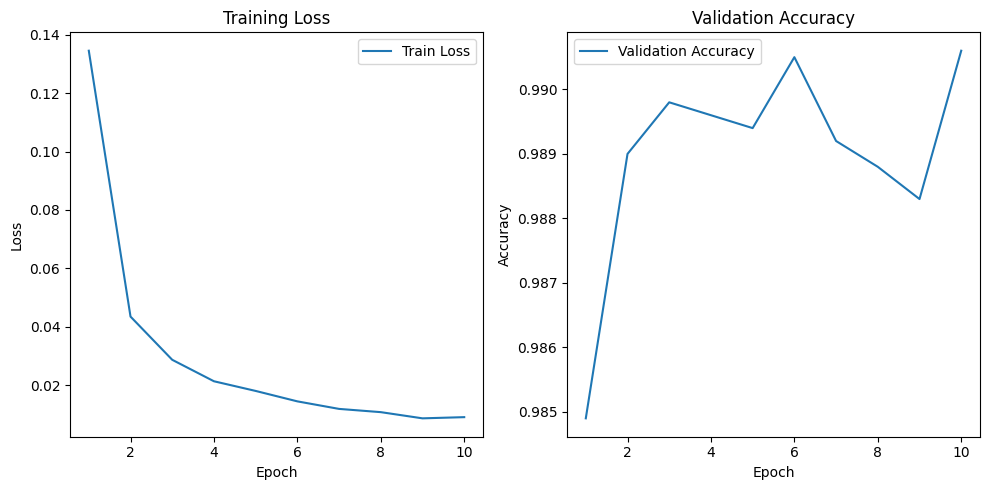

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import optuna
import matplotlib.pyplot as plt

# デバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MNISTデータセットの読み込み
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(
    './data', train=True, download=True, transform=transform)
val_dataset = datasets.MNIST(
    './data', train=False, download=True, transform=transform)

# モデルの定義


class Net(nn.Module):
    def __init__(self, n_units1, n_units2, n_units3):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, n_units1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_units1, n_units2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(7 * 7 * n_units2, n_units3)
        self.fc2 = nn.Linear(n_units3, 10)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = x.view(-1, 7 * 7 * self.conv2.out_channels)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return nn.functional.log_softmax(x, dim=1)

# 目的関数の定義


def objective(trial):
    # バッチサイズ、学習率などのハイパーパラメータ
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    n_units1 = trial.suggest_int("n_units1", 4, 32)
    n_units2 = trial.suggest_int("n_units2", 8, 64)
    n_units3 = trial.suggest_int("n_units3", 32, 256)

    # モデル、オプティマイザ、データローダの設定
    model = Net(n_units1, n_units2, n_units3).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # 学習ループ
    num_epochs = 5
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = nn.functional.nll_loss(output, labels)
            loss.backward()
            optimizer.step()

        # 精度の評価
        model.eval()
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                output = model(images)
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(labels.view_as(pred)).sum().item()

        accuracy = correct / len(val_loader.dataset)  # type: ignore
        trial.report(accuracy, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy  # type: ignore

# Optunaによる最適化
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=20)

# print("Best hyperparameters:", study.best_params)
# print("Best accuracy:", study.best_value)


# 最適なハイパーパラメータを使ってモデルを再学習
# best_params = study.best_params
best_params = {'batch_size': 64, 'lr': 0.001576026653549997,
               'n_units1': 25, 'n_units2': 28, 'n_units3': 232}
model = Net(best_params["n_units1"], best_params["n_units2"],
            best_params["n_units3"]).to(device)
optimizer = optim.Adam(model.parameters(), lr=best_params["lr"])
train_loader = DataLoader(
    train_dataset, batch_size=best_params["batch_size"], shuffle=True)
val_loader = DataLoader(
    val_dataset, batch_size=best_params["batch_size"], shuffle=False)

train_losses = []
val_accuracies = []

# 学習ループ
num_epochs = 10  # エポック数を増やす
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = nn.functional.nll_loss(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # 精度の評価
    model.eval()
    correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(labels.view_as(pred)).sum().item()

    accuracy = correct / len(val_loader.dataset)  # type: ignore
    val_accuracies.append(accuracy)
    print(
        f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Accuracy: {accuracy:.4f}")

# 学習曲線と精度のプロット
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()